# import

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,Dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import PIL

import seaborn as sns

from py_code.hsic import *

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn import metrics

from sklearn import datasets as clustering

device = 'cuda' if torch.cuda.is_available() else 'cpu'

mcolors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'w', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive', 'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip', 'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey', 'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen']
def toColor(label):
    return [mcolors[l] for l in label]

def plot2D(points,color = 'c',title='title', axes = None):
    if points.shape[1] != 2:
        print('need 2 dimension')
        return
    if axes is not None:
        plt.subplot(axes)
    plt.title(title)
    plt.scatter(points[:,0],points[:,1],c=color)

K:\Users\User\anaconda3\envs\RL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 432x288 with 0 Axes>

In [2]:
def to_cpu(x:torch.Tensor):
    return x.detach().clone().cpu()

def to_numpy(x:torch.Tensor):
    return x.detach().clone().cpu().numpy()


# Deep network

In [4]:
class deepNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(deepNetwork, self).__init__()
        # 3 layer network
        self.fc = nn.Sequential(
            nn.Linear(input_dim,64),
            nn.LeakyReLU(),
            nn.Linear(64,128),
            nn.LeakyReLU(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Linear(128,128),
            nn.LeakyReLU(),
            nn.Linear(128,output_dim),
        )
        
    def forward(self, x):
        return self.fc(x)

class kernelEncoder(nn.Module):
    def __init__(self, N, input_dim, output_dim):
        super(kernelEncoder, self).__init__()
        self.net = deepNetwork(input_dim, output_dim)
    def forward(self, x):
        return self.net(x)

class kernelDncoder(nn.Module):
    def __init__(self, N, input_dim, output_dim):
        super(kernelDncoder, self).__init__()
        self.net = deepNetwork(input_dim, output_dim)
    def forward(self, x):
        return self.net(x)

# global
torch.manual_seed(NETWORK_SEED)

# Data

## dataset

In [5]:
class myDataSet(Dataset):
    def __init__(self,N, _type:str = 'moon'):
        if _type == 'moon':
            self.points, self.true_labels = clustering.make_moons(
                n_samples=N, noise=0.05, random_state=42
            )
            self.label_num = 2
        elif _type == 'circle':
            self.points, self.true_labels = clustering.make_circles(
                n_samples=N, factor=0.5, noise=0.05, random_state=42
            )
            self.label_num = 2
        elif _type == 'blob':
            self.points, self.true_labels = clustering.make_blobs(
                n_samples=N, cluster_std=[1.0, 2.5, 0.5], random_state=42
            )
            self.label_num = 3
        elif _type == 'aniso':
            self.points, self.true_labels = clustering.make_blobs(
                n_samples=N, cluster_std=[1.0, 2.5, 1], random_state=42
            )
            transformation = [[0.6, -0.6], [-0.3, 0.6]]
            self.points = np.dot(self.points, transformation)
            print('aniso')
            self.label_num = 3
        
        self.points = torch.DoubleTensor(self.points).to(device)
        self.labelColor = toColor(self.true_labels)
    
    def groupIndex(self,label):
        ''' given label return points index'''
        return self.true_labels == label

    def group(self, label):
        ''' given label return points'''
        return self.points[self.groupIndex(label)]

    def sample(self, N):
        ''' random sample N '''
        index = np.random.choice(self.__len__(), N, replace=False)
        return self.points[index]

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx]

# test
if False:
    train_data = myDataSet(1000, 'blob')
    plot2D(train_data.points, title='Points')

# Functions

In [6]:
def f_function(x):
    global encoder, decoder
    return decoder(encoder(x))

def norm(x):
    return (x**2).sum()

def test_network():
    global encoder, train_data
    x = train_data.sample(3)
    with torch.no_grad():
        print(x)
        print(encoder(x))
        print(f_function(x))
        
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

## init theta

In [7]:
def init_weight(INIT_EPOCH = 10, ENCODER_LR = 0.01, DECODER_LR = 0.005):
    global encoder, decoder, dataSet

    encoderOptimizer = torch.optim.Adam(encoder.parameters(),lr=ENCODER_LR)
    decoderOptimizer = torch.optim.Adam(decoder.parameters(),lr=DECODER_LR)

    record_loss = []
    # train mode
    encoder.train()
    decoder.train()
    tqdm_ = tqdm(range(INIT_EPOCH))
    for i in tqdm_:
        for points in dataSet:
            encoderOptimizer.zero_grad()
            decoderOptimizer.zero_grad()
            
            loss = norm(points - encoder(points)) + \
                norm(points - f_function(points))
            loss.backward()
            
            encoderOptimizer.step()
            decoderOptimizer.step()
        tqdm_.set_postfix({'loss':loss.item()})

        record_loss.append(loss.item())

    plt.plot(record_loss)

    plt.show()
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(3)
    fig.tight_layout()
    plot2D(to_numpy(encoder(train_data.points)), train_data.labelColor, title='embedding', axes=121)
    plot2D(to_numpy(f_function(train_data.points)), train_data.labelColor, title='f_function', axes=122)
    plt.show()
    return record_loss[len(record_loss)-1]

# Check U mode

In [8]:
def check_U_mode():
    sample, sampleLabel = train_data.sample(BATCH_SIZE)
    U = to_numpy(update_U(sample))
    print('suggest y_dim = batch_size in check_U')
    while True:
        dim = [int(i) for i in input('dim: ').split(' ')]
        color = toColor(sampleLabel)
        if len(dim) == 1: # 1d
            x = U[:,dim[0]]
            y = sampleLabel
            plt.scatter(x, y, c = color)

        elif len(dim) == 2: # 2d
            x = U[:,dim[0]]
            y = U[:,dim[1]]
            plt.scatter(x, y, c = color)

        else: # 3d
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            x = U[:, dim[0]]
            y = U[:, dim[1]]
            z = U[:, dim[2]]
            ax.scatter( x, y, z, c = color)

        plt.show()

## Update U

In [9]:
def update_U(points, debug = False):
    global hsic, y_dim

    embedding_k = hsic._kernel_x(encoder(points))
    H = hsic.H
    D = np.diag(to_cpu(embedding_k).mean(1))
    D = torch.tensor(fractional_matrix_power(np.linalg.inv(D), 0.5).real,device=device)
    L =  H @ D @ embedding_k @ D @ H
    # eigenvalue
    _, eigenvectors = np.linalg.eig(to_cpu(L))
    # top C
    U = eigenvectors[:,:y_dim].real

    if debug: # check (U^T) * U = I
        print(U.transpose() @ U)

    return torch.DoubleTensor(U).to(device)

# CenterLoss

In [10]:
def centerLoss(data, center):

    labels = []
    for x in to_numpy(data):
        labels.append(np.argmin(abs(center - x).sum(axis=1)))

    cluster = torch.tensor(labels)
    cluster = F.one_hot(cluster.long(),num_classes=len(center) ).double().to(device)
    #mean = x.T @ cluster / cluster.sum(dim=0)
    #x_cluster_mean = (mean @ cluster.T).T
    #x - x_cluster_mean
    return norm(data - ((torch.nan_to_num((data.detach().T @ cluster) / cluster.sum(dim=0)) @ cluster.T).T))

## training loop

In [11]:
def train(EPOCH = 20, ITER = 5, ENCODER_LR = 0.01, DECODER_LR = 0.05, SCHEDULER_STEP = 5, SCHEDULAR_GAMMA = 0.99,
         LAMBDA = 0.01, LAMBDA_STEP=100, LAMBDA_MAX=100, LAMBDA_GAMMA=1):
    global encoder, decoder, dataSet, hsic

    encoderOptimizer = torch.optim.Adam(encoder.parameters(),lr=ENCODER_LR)
    decoderOptimizer = torch.optim.Adam(decoder.parameters(),lr=DECODER_LR)

    encode_LR_Scheduler = torch.optim.lr_scheduler.StepLR(encoderOptimizer, SCHEDULER_STEP, SCHEDULAR_GAMMA)
    decoder_LR_Scheduler = torch.optim.lr_scheduler.StepLR(decoderOptimizer, SCHEDULER_STEP, SCHEDULAR_GAMMA)


    hsic_loss = []
    norm_loss = []
    record_loss = []
    center_loss = []
    image_set = []
    # train mode
    encoder.train()
    decoder.train()
    tqdm_ = tqdm(range(EPOCH))
    for i in tqdm_:
        kmeans = KMeans(n_clusters= K_CENTER, n_init=3,random_state=0, max_iter=30).fit(to_numpy(encoder(train_data.points)))
        k_center = kmeans.cluster_centers_
        for points in dataSet:
            # update D, U
            hsic.update_D(hsic._kernel_x(points))
            U = update_U(points)
            # D U fixed, update ~theta
            for _ in range(ITER):
                encoderOptimizer.zero_grad()
                decoderOptimizer.zero_grad()

                x = encoder(points)
                _hsic = hsic(x, U)
                _norm = LAMBDA * norm(points - f_function(points))

                centerloss_ = CENTER * centerLoss(x, k_center) if WITH_CENTER_LOSS else torch.zeros(1,device=device)
                loss = _hsic - _norm - centerloss_
                # SGA
                loss = -loss
                loss.backward()
                
                encoderOptimizer.step()
                decoderOptimizer.step()

        decoder_LR_Scheduler.step()
        encode_LR_Scheduler.step()
        center_loss.append(centerloss_.item())
        hsic_loss.append(_hsic.item())
        norm_loss.append(_norm.item())
        record_loss.append(-(loss.item()))
        tqdm_.set_postfix({'loss': -(loss.item())})

        if i % LAMBDA_STEP == 0 and LAMBDA < LAMBDA_MAX:
            LAMBDA *= LAMBDA_GAMMA
            LAMBDA = min(LAMBDA, LAMBDA_MAX)

        if SAVE_GIF and i % SAVE_STEP == 0:
            image_set.append(plot_result(U = update_U(points),title= str(i)))
    if SAVE_GIF:
        image_set[0].save(IMAGE_PATH  + 'result.gif',save_all=True, append_images=image_set[1:], optimize=False, duration=200, loop=0)

    # plot
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(3)
    fig.tight_layout()
    plt.subplot(141)
    plt.title("loss")
    plt.plot(record_loss)
    plt.subplot(142)
    plt.ticklabel_format(useOffset=False)
    plt.title("hsic loss")
    plt.plot(hsic_loss)
    plt.subplot(143)
    plt.title("norm loss")
    plt.plot(norm_loss)
    plt.subplot(144)
    plt.title("center loss")
    plt.plot(center_loss)
    plt.show()
    plt.savefig(IMAGE_PATH + 'training_loss')
    plt.close(fig)

## plot result

In [12]:
def plot_result(U = None, title = ''):
    global encoder, train_data

    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(8)
    fig.tight_layout()
    plot2D(to_numpy(train_data.points), train_data.labelColor, title='true_label', axes=221)
    if U is not None:
        plot2D(to_numpy(U), title='U(sample)', axes=222)
    plot2D(to_numpy(encoder(train_data.points)), train_data.labelColor, title='embedding', axes=223)
    plot2D(to_numpy(f_function(train_data.points)), train_data.labelColor, title='f_function', axes=224)
    plt.show()
    plt.savefig(IMAGE_PATH + 'training_result')
    fig.suptitle(title, fontsize=16)
    
    img = None
    if SAVE_GIF:
        img =  fig2img(fig)

    plt.close(fig)
    return img

    
def plot_distribution(axis = 0):
    global train_data
    
    fig, axes = plt.subplots(2, train_data.label_num, figsize=(4*train_data.label_num, 8))
    for i in range(train_data.label_num):
        axes[0,i].set_title(f'original label {i} axis-{axis}')
        axes[1,i].set_title(f'embedding label {i} axis-{axis}')

        sns.histplot(to_numpy(train_data.points[train_data.groupIndex(i),axis]),ax=axes[0,i])
        sns.histplot(to_numpy(encoder(train_data.points))[train_data.groupIndex(i),axis],ax=axes[1,i],bins=20)
    plt.show()
    plt.savefig(IMAGE_PATH + 'dist')
    plt.close(fig)

## Accuracy

In [24]:
def compare(a, b):
    global train_data
    if len(a) != len(b):
        print('size not match')
        return
    label_num = train_data.label_num
    a = np.eye(label_num)[a]
    b = np.eye(label_num)[b]
    aa = a.T @ a
    bb = b.T @ a
    acc = 0
    for i,o in zip(range(label_num),np.argmax(bb,axis=1)):
        acc += bb[i,o]/aa[i,i]
    acc = (acc / label_num)
    #print(acc)
    #print(aa)
    #print(bb)
    return acc, bb

def apply_kmeans(k, data, title='title'):
    global train_data
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    print(title,end=': ')
    comp = compare(train_data.true_labels,kmeans.labels_)
    acc = normalized_mutual_info_score(train_data.true_labels,kmeans.labels_)
    print('label rate=',comp[0],', acc=', acc)

    plot2D(to_numpy(train_data.points),color=toColor(kmeans.labels_) , title=title)
    plt.savefig(IMAGE_PATH + f'k_means_{title}')
    plt.show()
    plt.clf()
    
    return acc
    
def accuracy():
    global encoder, train_data
    apply_kmeans(train_data.label_num, to_numpy(train_data.points), 'oringal')
    apply_kmeans(train_data.label_num, to_numpy(encoder(train_data.points)), 'embedding')

# RUN

## Hyperparameter

cuda
aniso


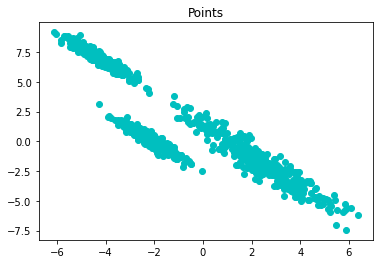

In [38]:

NETWORK_SEED = 0
DATASET_SEED = 42

# init loop
INIT_EPOCH = 30

INIT_EBCODER_LR = 0.01
INIT_DECODER_LR = 0.005

# train loop
EPOCH = 50
ITER = 6

ENCODER_LR = 0.01
DECODER_LR = 0.005

SCHEDULER_STEP = 10
SCHEDULER_GAMMA = 0.9

# epoch every LAMBDA_STEP, lambda *= LAMBDA_GAMMA
LAMBDA = 0.000055
LAMBDA_STEP = 30
LAMBDA_MAX = 1
LAMBDA_GAMMA = 1.2

# center loss
WITH_CENTER_LOSS = False    
CENTER = 0.0002 # weight
K_CENTER = 2



# number of sample
N = 1000
BATCH_SIZE = 128
x_dim = 2 # X
y_dim = 2 # U
embedding_dim = x_dim

DEBUG = False
# gif
SAVE_GIF = True
SAVE_STEP = 5

# dataset use the moon or blob or aniso or circle
dataset ='aniso'
print(device)

# dataset
train_data = myDataSet(N, dataset)
plot2D(train_data.points.cpu(), title='Points')
plt.show()

# global
encoder = kernelEncoder(N, x_dim, embedding_dim).double().to(device)
decoder = kernelDncoder(N, embedding_dim, x_dim).double().to(device)

dataSet = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True)
hsic = HSIC(BATCH_SIZE)

sample = train_data.sample(BATCH_SIZE)

if DEBUG:
    print('-----hsic test-----')
    hsic.selfTest()
    print('\n\n-----U test----')
    
    _ = update_U(sample,debug=True)

## Init

100%|███████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.20it/s, loss=3.58]


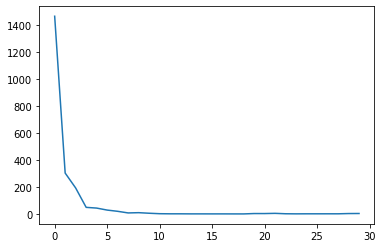

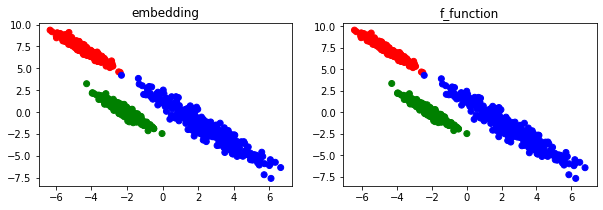

In [39]:
m=init_weight(INIT_EPOCH, INIT_EBCODER_LR, INIT_DECODER_LR)
if DEBUG:
    print('-----network test----')
    test_network()

## train

  0%|                                                                              | 0/50 [00:00<?, ?it/s, loss=0.0568]

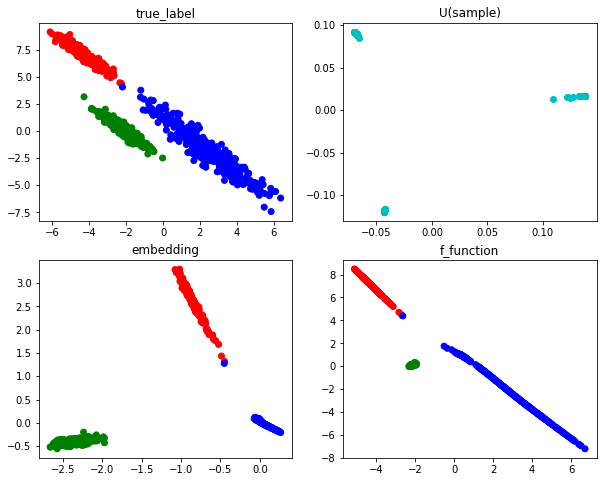

 10%|███████                                                               | 5/50 [00:04<00:33,  1.34it/s, loss=0.0619]

<Figure size 432x288 with 0 Axes>

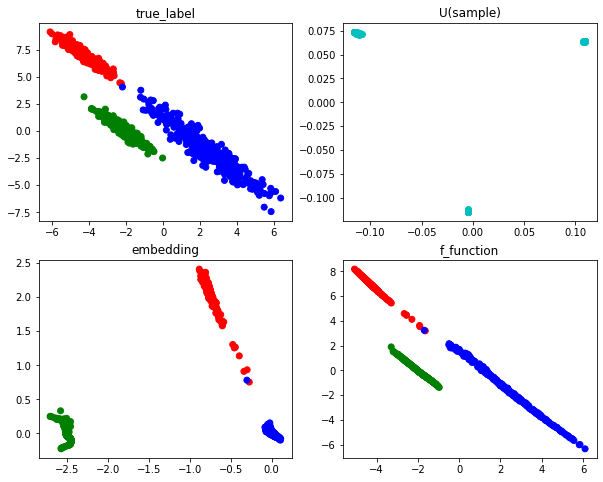

 20%|██████████████                                                        | 10/50 [00:09<00:34,  1.17it/s, loss=0.063]

<Figure size 432x288 with 0 Axes>

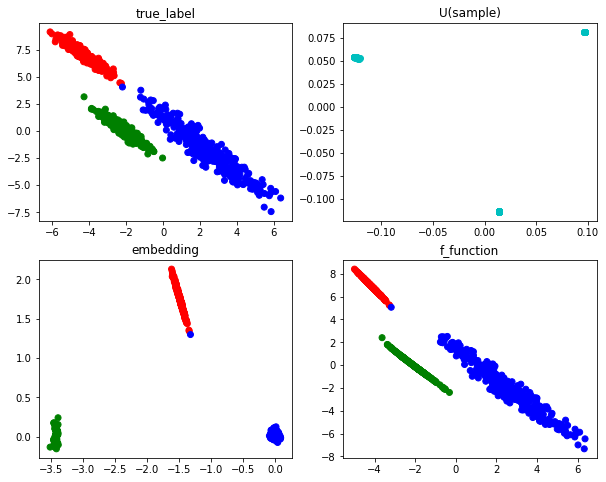

 30%|████████████████████▋                                                | 15/50 [00:15<00:36,  1.05s/it, loss=0.0631]

<Figure size 432x288 with 0 Axes>

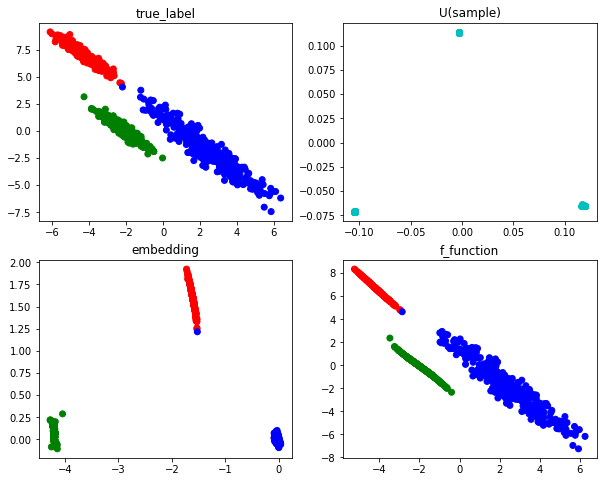

 40%|███████████████████████████▌                                         | 20/50 [00:21<00:35,  1.19s/it, loss=0.0629]

<Figure size 432x288 with 0 Axes>

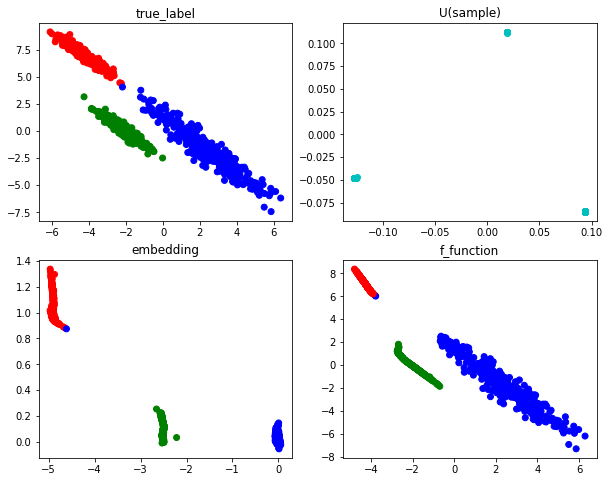

 50%|██████████████████████████████████▌                                  | 25/50 [00:27<00:28,  1.16s/it, loss=0.0635]

<Figure size 432x288 with 0 Axes>

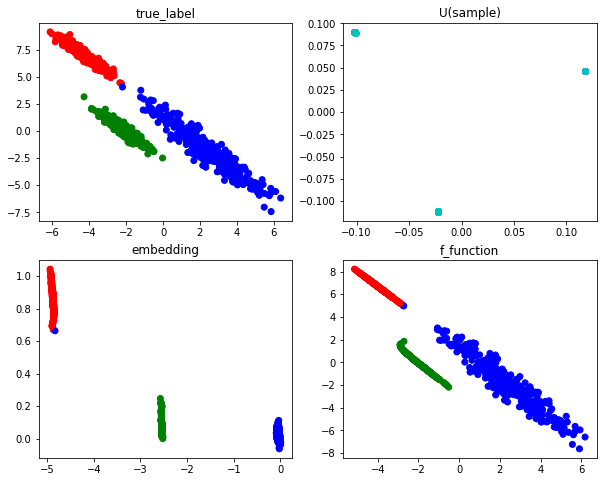

 60%|█████████████████████████████████████████▍                           | 30/50 [00:32<00:17,  1.11it/s, loss=0.0641]

<Figure size 432x288 with 0 Axes>

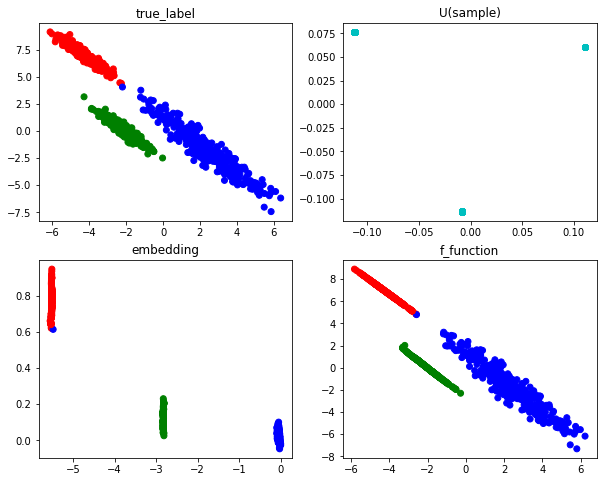

 70%|████████████████████████████████████████████████▎                    | 35/50 [00:36<00:12,  1.16it/s, loss=0.0634]

<Figure size 432x288 with 0 Axes>

In [ ]:
train(EPOCH, ITER, ENCODER_LR, DECODER_LR, SCHEDULER_STEP, SCHEDULER_GAMMA,
        LAMBDA, LAMBDA_STEP, LAMBDA_MAX, LAMBDA_GAMMA)

## plot training result

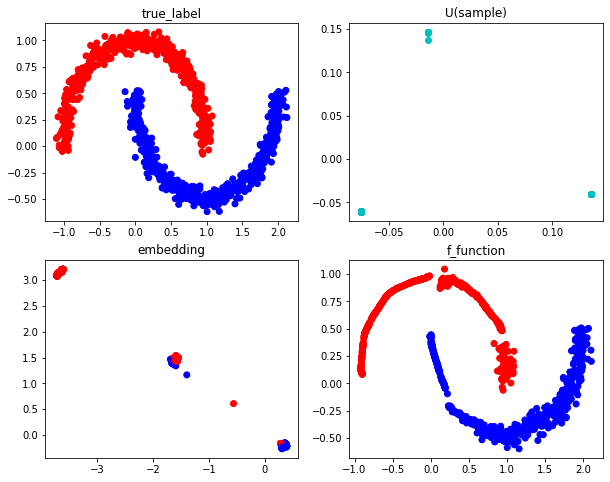

<Figure size 432x288 with 0 Axes>

In [33]:
encoder.eval()
decoder.eval()
# plot
plot_result(U = update_U(sample))
if DEBUG:
    plot_distribution(axis = 0)

## k-means eval

oringal: label rate= 0.745 , acc= 0.1809221410654393


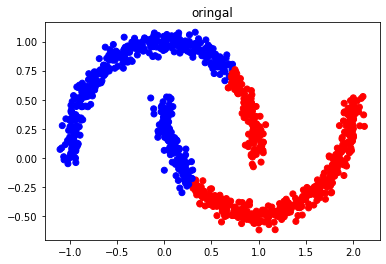

embedding: label rate= 0.8280000000000001 , acc= 0.3451500228557461


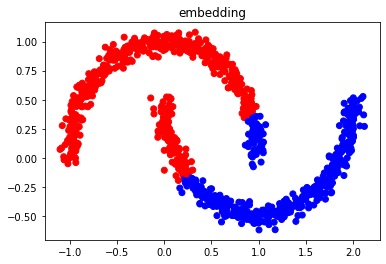

<Figure size 432x288 with 0 Axes>

In [34]:
#encoder.eval()
#decoder.eval()
# eval
accuracy()